# Model Building
Now that we've cleaned and analyzed our dataset, we can begin training models to see which is the best at predicting exoplanets. 

First we need to read in our cleaned dataset.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
df = pd.read_csv('data_cleaned.csv')
df.head(5)

Now we need to split the data into features (X) and labels (y). Koi_pdisposition is going to be our label, which takes a 0 or a 1 value corresponding to a **FALSE POSITIVE** or **CANDIDATE** respectively. The rest of the variables are going to be our features. We will have 18 features in total. 

In [6]:
# Create X and y variables
X = df.drop(columns=['koi_pdisposition'])
y = df['koi_pdisposition']

After that we can split our data into training and testing sets using the train_test_split() function. This splits up our dataset so that 70% of it will be used for training and 30% will be used for testing to evaluate the model. 

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Random Forest 
The first model we are going to train is going to use the Random Forest algorithm. This algorithm combines the predictions of multiple individual decision trees to improve overall accuracy and generalization. I chose to train this type of model first because it is particulary helpful for binary classification problems and this specific dataset. Random Forest models provides a measure of feature importance which helps us understand which features are most useful for making accurate predictions. Random Forest can also handle outliers in data very well. As we've seen in the exploratory data analysis, many of these features have large outliers which the Random Forest model will be less sensitive to.  

Below we will create an instance of the Random Forest Classifier, fit it to the training data, and make predictions on the test data. 

In [8]:
# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=123)

# Train the model
rf_classifier.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_classifier.predict(X_test)

Now we can check the accuracy, precision, recall, and f1 score for this Random Forest model which are important metrics for classification problems. 

**Accuracy** measures the proportion of correctly predicted instances our of the total instances of the dataset. This metric is usually better suited for balanced datasets like the one we are using where both classes are just as common as the other. 

**Precision** measures the proportion of correctly predicted positive instances our of all instances that were predicted as positive by the model. This metric focuses on the quality of positive predictions.

**Recall** measures the proportion of correctly predicted positive instances out of all actual positive instances. 

**F1 Score** provides a balance between precision and recall. It considers both false positives and false negatives. 

In [9]:
# Show results
model = {}
model['Random Forest'] = rf_classifier
rf_model = pd.DataFrame(index = model.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1'])

rf_model['Accuracy'] = accuracy_score(y_test, y_pred)
rf_model['Precision'] = precision_score(y_test, y_pred)
rf_model['Recall'] = recall_score(y_test, y_pred)
rf_model['F1'] = f1_score(y_test, y_pred)  

rf_model

,Accuracy,Precision,Recall,F1
Random Forest,0.988502,0.987266,0.988006,0.987636


As you can see the model did an outstanding job at predicting exoplanets! All of the metrics we calculated were above 98%. 

Let's check to see which features were most important in the training of this model. 

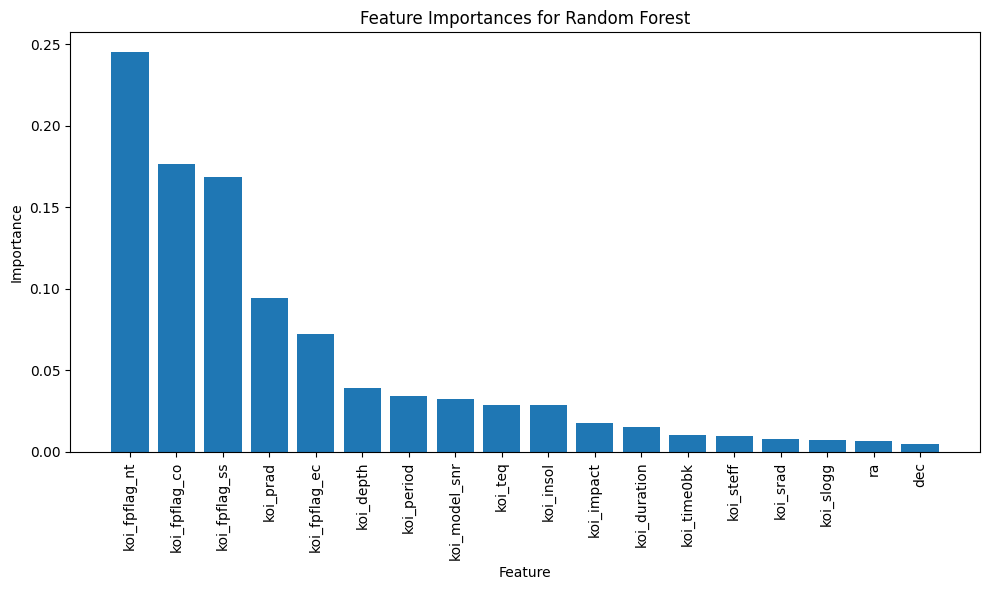

In [10]:
# Feature Importances For Random Forest
importances = rf_classifier.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation = 90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances for Random Forest')
plt.tight_layout()
plt.show()

It's important to note that feature importance does not imply causation. It indicates a correlation between the variables and the label within the context of our dataset. It is a measure of how much each feature contributes to the models ability to make accurate predictions. 

Four out of the top five most important features were the flag variables. They made up around 70% of the important variables while the other features were all below 10%. This is somewhat unsurprising considering what we saw in the exploratory data analysis where the flag variables returing a 1 was usually a good indicator of the label being a **FALSE POSITIVE**. So it makes sense why the Random Forest model likes to use these features the most to make accurate predictions. 

## Reduced Random Forest

Now let's say we don't have access to the flag features. Imagine that NASA launches a new telescope doens't keep track of the flag data. Can we still make accurate predictions using the rest of the features? To do that we have to create new X variables without any of the flag data and follow the same steps as before. We will use the Random Forest algorithm again. 

In [11]:
# Create new X variables
selected_features = ['koi_period', 'koi_time0bk', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol',
       'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad', 'ra', 'dec']

reduced_X_train = X_train[selected_features]
reduced_X_test = X_test[selected_features]

In [12]:
# Initialize Random Forest Classifier
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=1234)

# Train the model
rf_reduced.fit(reduced_X_train, y_train)

# Evaluate the model
y_pred_reduced = rf_reduced.predict(reduced_X_test)

In [13]:
# Show results
new_model = {}
new_model['Reduced Random Forest'] = rf_reduced

reduced_rf_model = pd.DataFrame(index = new_model.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1'])

reduced_rf_model['Accuracy'] = accuracy_score(y_test, y_pred_reduced)
reduced_rf_model['Precision'] = precision_score(y_test, y_pred_reduced)
reduced_rf_model['Recall'] = recall_score(y_test, y_pred_reduced)
reduced_rf_model['F1'] = f1_score(y_test, y_pred_reduced)  

reduced_rf_model

,Accuracy,Precision,Recall,F1
Reduced Random Forest,0.840418,0.823486,0.835832,0.829613


As you can see, all of the metrics have dropped significantly down to around 83%. This shows how siginifant the flag features are when training these Random Forest models. 

Let's now see what the most important features are:

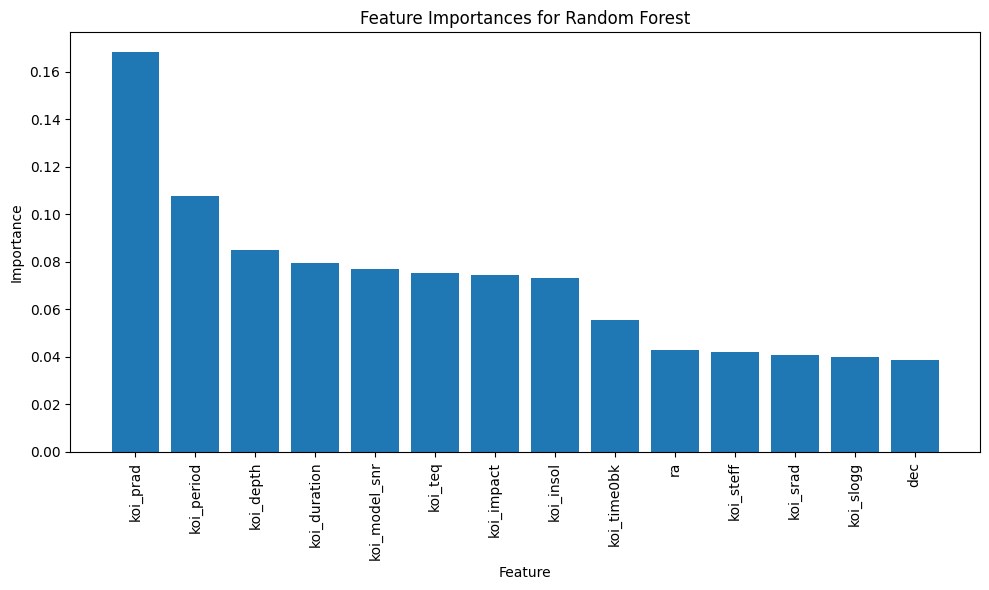

In [14]:
# Feature Importances For Reduced Random Forest
reduced_importances = rf_reduced.feature_importances_

reduced_feature_importance_df = pd.DataFrame({'Feature': reduced_X_train.columns, 'Importance': reduced_importances})
reduced_feature_importance_df = reduced_feature_importance_df.sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (10, 6))
plt.bar(reduced_feature_importance_df['Feature'], reduced_feature_importance_df['Importance'])
plt.xticks(rotation = 90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances for Random Forest')
plt.tight_layout()
plt.show()

We can see that the most important feature for our new Random Forest model is koi_prad which is the planetary radius. It only makes up around 16% of the importance compared to the 25% of the most important feature in the last model.  

## Hyperparameter Tuning for Random Forest, Gradient Boosting Machines, and Logistic Regression
Let's see if we can improve this model or find a different model that produces better results. One way we can improve this model is to tune the **hyperparameters**. Hyperparameters are parameters of a machine learning model that are not learned from the data but are set before training the model. These parameters control various aspects of the model and can significantly impact the performance. In the case of the Random Forest model, we just used the default hyperparameters that were set when we initialized the Random Forest classifier. One way we can optimize the hyperparameters is by using a **Grid Search**. This method systematically searches through a specified hyperparameter space and finds the best combination of hyperparameters that results in the best model performance. 

We will use **Grid Search** to optimize our hyperparameters for the Random Forest model, along with two more machine learning models: **Gradient Boosting Machines (GBM)** and **Logistic Regression**. **GBM** is a model which combines the predictions of multiple weak learners (usually decision trees) to create a strong predictive model. **Logistic Regression** models the probability of a binary outcome as a logistic function. These are two more models which can be used for our binary classification task. Let's see which one performs the best:

In [15]:
# Define the hyperparameter grid for Random Forest
rf_hyperparams = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
rf_grid_search = GridSearchCV(rf_reduced, rf_hyperparams, cv=5, scoring='accuracy')
rf_grid_search.fit(reduced_X_train, y_train)

# Get best parameters and best accuracy score
rf_best_params = rf_grid_search.best_params_
rf_best_accuracy = rf_grid_search.best_score_

In [16]:
# GBM with Hyperparameter Tuning 
gbm_classifier = GradientBoostingClassifier(random_state=1234)

# Define the hyperparameter grid for Gradient Boosting Machines
gbm_hyperparams = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 10]
}

# Grid search with cross-validation
gbm_grid_search = GridSearchCV(gbm_classifier, gbm_hyperparams, cv=5, scoring='accuracy')
gbm_grid_search.fit(reduced_X_train, y_train)

# Get best parameters and best accuracy score
gbm_best_params = gbm_grid_search.best_params_
gbm_best_accuracy = gbm_grid_search.best_score_

In [ ]:
# Logistic Regression with Hyperparameter Tuning 
lr_classifier = LogisticRegression(random_state=1234)

# Define the hyperparameter grid for Support Vector Machines
lr_hyperparams = {
    'C': [0.001, 0.01, 0.1, 1],  # Regularization parameter
    'penalty': ['l1', 'l2']  # Regularization type (L1 or L2)
}

# Grid search with cross-validation
lr_grid_search = GridSearchCV(lr_classifier, lr_hyperparams, cv=5, scoring='accuracy')
lr_grid_search.fit(reduced_X_train, y_train)

# Get best parameters and best accuracy score
lr_best_params = lr_grid_search.best_params_
lr_best_accuracy = lr_grid_search.best_score_

In [18]:
print("Random Forest Accuracy ", rf_best_accuracy)
print("Gradient Boosting Machines Accuracy ", gbm_best_accuracy)
print("Logistic Regression Accuracy ", lr_best_accuracy)

Random Forest Accuracy  0.8464293568477468
Gradient Boosting Machines Accuracy  0.8480719274920154
Logistic Regression Accuracy  0.7255776179934829


As you can see the **Random Forest** and **Gradient Boosting Machines** models have nearly identical accuracy scores at around 84% while the **Logistic Regression** model is 12% lower. This lower accuracy might be because **Logistic Regression** assumes a linear relationship between the features and target variable. Since our data does have some nonlinear relationships, the **Logistic Regression** algorithm may not capture them effectively. High multicollinearity between features also leads to unstable coefficient estimates which can impact prediction accuracy for **Logistic Regressions**. 

Let's compare the models even further by looking at an Receiver Operating Characterisitc (ROC) curve:

## Reciever Operating Characteristic (ROC) curve

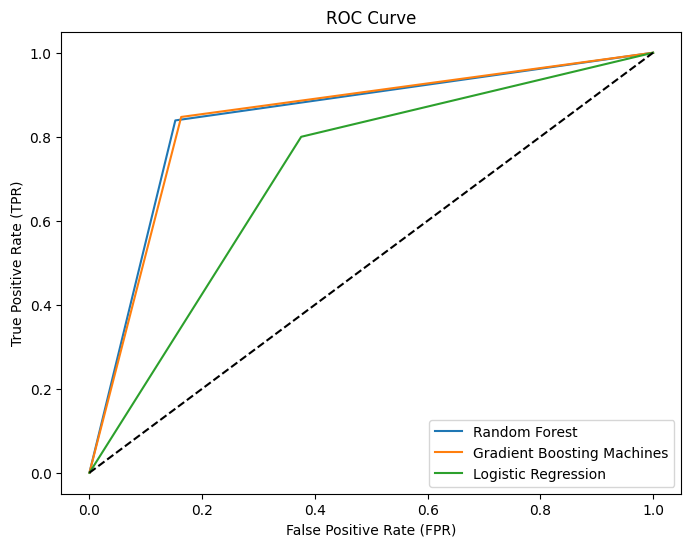

In [19]:
# Find the predicted values  
y_pred_rf = rf_grid_search.predict(reduced_X_test)
y_pred_gbm = gbm_grid_search.predict(reduced_X_test)
y_pred_lr = lr_grid_search.predict(reduced_X_test)

# fpr = false positive rate, tpr = true positive rate, thresholds = corresponding thresholds
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)  # Random Forest
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(y_test, y_pred_gbm)  # GBM
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)

# Plot the roc curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_gbm, tpr_gbm, label='Gradient Boosting Machines')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference (random classifier)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

An ROC curve is a way to measure performance between binary classification problems. It measures the trade-off between the true positive rate and the false positive rate as you change the thresholds for classifying a positive outcome. The true positive rate is also known as the sensitivity or the proportion of actual **CANDIDATES** correctly predicted by the model. The false positive rate is also known as the complement of specificity or the proportion of actual **FALSE POSITIVES** incorrectly predicted as a **CANDIDATE** by the model. So we want to model to have a high true positive rate and a low false positive rate. When looking at the graph, this corressponds to a model that is closest to the top left corner. The diagonal dashed line is what a random classifier guessing the classes would look like. All three of our models perform better than a model randomly guessing.    

One way to measure this graph is to look at the area under the curve (AUC) for all three models. A higher AUC indicates better discrimination between the classes. In our case, a higher AUC means the model is better at distinguishing between **CANDIDATE** and **FALSE POSITIVE**. 

In [24]:
# Calculate AUC for the three models
auc_rf = roc_auc_score(y_test, y_pred_rf)  # AUC for Random Forest
auc_gbm = roc_auc_score(y_test, y_pred_gbm)  # AUC for GBM
auc_lr = roc_auc_score(y_test, y_pred_lr)  # AUC for Logistic Regression

print(f'AUC - Random Forest: {auc_rf}')
print(f'AUC - Gradient Boosting Machines: {auc_gbm}')
print(f'AUC - Logistic Regression: {auc_lr}')

AUC - Random Forest: 0.843243417353823
AUC - Gradient Boosting Machines: 0.8421580225512244
AUC - Logistic Regression: 0.7120995166479259


## Final Model Decision 

When figuring out which model performs best, we can immediately rule out Logisitic Regression. It has a significantly lower AUC and accuracy score than the Random Forest and GBM models. Now lets compare the Random Forest and Gradient Boosting Machine metrics:

AUC - RF: 0.8432

AUC - GBM: 0.8422

Accuracy - RF: 0.8464

Accuracy - GBM: 0.8481

Note: I am using accuracy as the primary metric over other evaluation metrics (precision, recall, f1 score) because it provides an overall measure of correct predictions. Accuracy is also a good metric when working with a balanced dataset and when the cost of a false positive and false negative are roughly equal. There is no significant damage if we incorrectly identify an exoplanet or fail to identify one.  

The AUC of the Random Forest model is just slightly better than the GBM model. However, the accuracy of the GBM model is slightly better than the Random Forest model. Since these differences are so small (around one one-thousandth) we must find a different way to distinguish between them. 

Random Forest models are generally easier to interpret than GBM models. In a Random Forest, the model is an ensemble of decision trees where the final prediction is just the majority vote of all the individual trees. The model is easier to understand because it is made up of simpler components. For a GBM model, each new tree is meant to improve upon the last one. This sequential nature can make it harder to determine how much each tree contributes to the overall prediction. While GBM models can provide feature importance scores like a Random Forest, they can vary depending on the order of which features are considered during training. GBM models also tend to be more computationally intensive during training than Random Forest models. They can be more compelx to tune and may require more hyperparameter optimization. When tuning hyperparameters, the GBM model took much longer than the Random Forest model. If I ever need to go back and tune the hyperparameters more, I will save much more time by choosing the Random Forest model.    

For these reasons, the **Random Forest model** is the best model for my exoplanet classification project. All of the metrics for this model can be found below:

## Random Forest Metrics

In [27]:
# Model Evaluation on Testing Data
# Choose the best model based on validation accuracy
best_model = rf_grid_search.best_estimator_  # or gbm_grid_search.best_estimator_ or svm_grid_search.best_estimator_

# Evaluate on testing data
y_pred = best_model.predict(reduced_X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print("Best Model: Random Forest")
print("Best Parameters:", rf_best_params)
print("Validation Accuracy:", rf_best_accuracy)
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("AUC:", auc_rf )


Best Model: Random Forest
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Validation Accuracy: 0.8464293568477468
Test Accuracy: 0.8435540069686411
Test Precision: 0.8270509977827051
Test Recall: 0.8388305847076462
Test F1 Score: 0.8328991440267957
AUC: 0.843243417353823
